# The Impact of Model Output Transformations on ROC

Risk Assessment tools are currently used to assist in decision-making at several points in the criminal justice system. These tools take in some data about an individual and to provide a 'risk score' for an individual that's reflective of their likelihood of committing a specific behavior in the future. A standard outcome of interest is recidivism, or `a person's relapse into criminal behavior, often after the person receives sanctions or undergoes intervention for a previous crime` ([NIJ](https://www.nij.gov/topics/corrections/recidivism/Pages/welcome.aspx)). One thing the field seems to have settled on is using area under the receiver operating characteristic (AUC ROC) scores in evaluating the accuracy of these tools. AUC is a sensible evaluation measure since it's indifferent to base rates and has a straightforward interpretation. 


## COMPAS & Risk Assessment Scores
In the world of risk assessment, the most well known risk assessment tool is probably COMPAS by Noirthpointe. COMPAS is a black box algorithm that is used to predict recidivism, and was the subject of an [investigation by ProPublica](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm) as well as a [lawsuit in Wisconsin](https://www.nytimes.com/2016/06/23/us/backlash-in-wisconsin-against-using-data-to-foretell-defendants-futures.html). 

Northpointe [claims](http://www.northpointeinc.com/files/downloads/FAQ_Document.pdf) that the with the COMPAS tool "AUCs ranged from .68 to .71 in the full sample" for general recidivism, with an "AUC 0.67 for violent recidivism". In reading these claims, it is important to consider there is [some evidence of authorship bias](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0072484) in model evaluation, to the extent that "[...] studies authored by tool designers reported predictive validity findings around two times higher those of investigations reported by independent authors".

Scores from the COMPAS tool go through several transformations before they end up in a decision maker's hands. The first output is a `raw score` from the model itself, which appears to be a normally distributed score. These raw scores are converted to a `decile score`, which I assume is based on the full range of scores. Finally, Northpointe also privdes a mapping of decile scores to qualitative risk levels following this mapping:

- **1-4**: Low risk
- **5-7**: Medium risk
- **8+**: High risk

In evaluating model accuracy, it's relevant to look at the model accuracy of the information presented to the decision maker. That is, if a judicial official views receives a report with the qualitative risk level (High, Medium, Low) then we should be concerned with the accuracy of those model scores. The the accuracy of the `raw score` or the `decile score` doesn't really matter -- the user of this tool never sees this underlying information, though the reported accuracy of the tool may depend on these pre-transformed measures.

We'll evaluate model accuracy at each one of these transformations. Using the [data](https://github.com/propublica/compas-analysis/) published by ProPublica that contains COMPAS scores and outcomes for individuals in Broward County, Florida.

## Outline
This analysis is comprised of 3 parts:

1. Processing & Exploring the COMPAS dataset from ProPublica
2. Analyzing AUC ROC scores by raw/decile/qualitative transformation
3. Analyzing the general impact of binning on model accuracy

## 1. Data Processing & Exploring
The final dataset ProPublica uses doesn't have the raw score, but they do provide the raw COMPAS data, which we will merge into the clean dataset. I couldn't find a clear ID or case number to merge on at a glance, so we're merging on `first name`, `last name`, and `compas screening date`. This merging scheme may lead to some discrepancies between the dataset ProPublica used for analysis, but should match most cases in general. In general, I follow [their process](https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb) of filtering observations based on data quality assumptions.

In [1]:
import pandas as pd
import seaborn as sns

sns.set_context("notebook", font_scale=1.5)
import matplotlib.pyplot as plt

plt.style.use("ggplot")
import numpy as np
import scipy

from sklearn.metrics import roc_auc_score

%matplotlib inline

In [2]:
def read_pp_compas_data(csv_url):
    d = (
        pd.read_csv(csv_url, parse_dates=["compas_screening_date"])
        .query("days_b_screening_arrest <= 30")
        .query("days_b_screening_arrest >= -30")
        .query("is_recid != -1")
        .query('c_charge_degree != "O"')
        .query('score_text != "N/A"')
        .assign(
            score_text=lambda x: x["score_text"].map(
                {"Low": 1, "Medium": 2, "High": 3}
            ),
            v_score_text=lambda x: x["v_score_text"].map(
                {"Low": 1, "Medium": 2, "High": 3}
            ),
        )
    )
    return d

In [3]:
compas_recid = read_pp_compas_data(
    "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
)
compas_recid_v = read_pp_compas_data(
    "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years-violent.csv"
)

In [4]:
compas_recid_simple = compas_recid[
    ["first", "last", "compas_screening_date", "decile_score", "score_text", "is_recid"]
]
compas_recid_v_simple = compas_recid_v[
    [
        "first",
        "last",
        "compas_screening_date",
        "v_decile_score",
        "v_score_text",
        "is_violent_recid",
    ]
]

compas_scores = pd.merge(
    compas_recid_simple,
    compas_recid_v_simple,
    on=["first", "last", "compas_screening_date"],
    how="outer",
)

In [5]:
compas_scores.head()

,first,last,compas_screening_date,decile_score,score_text,is_recid,v_decile_score,v_score_text,is_violent_recid
0,miguel,hernandez,2013-08-14,1.0,1.0,0.0,1.0,1.0,0.0
1,kevon,dixon,2013-01-27,3.0,1.0,1.0,1.0,1.0,1.0
2,ed,philo,2013-04-14,4.0,1.0,1.0,NaN,NaN,NaN
3,marsha,miles,2013-11-30,1.0,1.0,0.0,1.0,1.0,0.0
4,edward,riddle,2014-02-19,6.0,2.0,1.0,NaN,NaN,NaN


### Read Raw Score Data

In [6]:
def read_compas_raw(csv_url):
    columns = ["LastName", "FirstName", "Screening_Date", "RawScore", "DisplayText"]
    colnames = {
        "FirstName": "first",
        "LastName": "last",
        "Screening_Date": "compas_screening_date",
    }

    d = (
        pd.read_csv(csv_url, parse_dates=["Screening_Date"], usecols=columns)
        .rename(columns=colnames)
        .assign(
            last=lambda x: x["last"].str.lower(), first=lambda x: x["first"].str.lower()
        )
    )
    d_recid = d.loc[lambda x: x["DisplayText"] == "Risk of Recidivism"]
    d_viol = d.loc[lambda x: x["DisplayText"] == "Risk of Violence"]

    d_recid = d_recid.rename(columns={"RawScore": "r_raw_score"})
    d_viol = d_viol.rename(columns={"RawScore": "v_raw_score"})

    del d_recid["DisplayText"]
    del d_viol["DisplayText"]

    return d_recid, d_viol

In [7]:
recid_raw, viol_raw = read_compas_raw(
    "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-raw.csv"
)

In [8]:
complete_scores = pd.merge(
    compas_scores, recid_raw, on=["first", "last", "compas_screening_date"], how="left"
)
complete_scores = pd.merge(
    complete_scores, viol_raw, on=["first", "last", "compas_screening_date"], how="left"
)

In [9]:
complete_scores.head()

,first,last,compas_screening_date,decile_score,score_text,is_recid,v_decile_score,v_score_text,is_violent_recid,r_raw_score,v_raw_score
0,miguel,hernandez,2013-08-14,1.0,1.0,0.0,1.0,1.0,0.0,-2.78,-4.31
1,kevon,dixon,2013-01-27,3.0,1.0,1.0,1.0,1.0,1.0,-0.76,-3.07
2,ed,philo,2013-04-14,4.0,1.0,1.0,NaN,NaN,NaN,-0.66,-2.26
3,marsha,miles,2013-11-30,1.0,1.0,0.0,1.0,1.0,0.0,-1.93,-3.30
4,edward,riddle,2014-02-19,6.0,2.0,1.0,NaN,NaN,NaN,-0.16,-2.89


#### Some final checks

In [10]:
complete_scores = complete_scores.dropna(subset=["r_raw_score", "v_raw_score"])

print("Has Recid Outcome:\t", complete_scores["is_recid"].notnull().sum())
print("Has Violent Recid:\t", complete_scores["is_violent_recid"].notnull().sum())

Has Recid Outcome:	 6209
Has Violent Recid:	 3998


### Explore Distributions of Scores
Below we'll take a look at the distributions of each score to get a better understanding of what the data looks like that's coming out of the model. We examine the general recidivism cases below, the violent recidivism scores are not pictured.

#### Raw Score Distributions

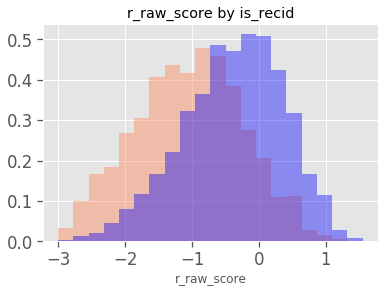

In [11]:
def bin_plot(df, values_column, binary_by_column, n_bins=25, bins=None):
    d_true = df.loc[lambda x: x[binary_by_column] == True][values_column]
    d_false = df.loc[lambda x: x[binary_by_column] == False][values_column]

    d_min, d_max = df[values_column].min(), df[values_column].max()

    if not bins:
        bins = np.arange(d_min, d_max, (d_max + 1 - d_min) / n_bins)

    fig, ax = plt.subplots()
    sns.distplot(d_false, ax=ax, bins=bins, kde=False, norm_hist=True, color="coral")
    sns.distplot(d_true, ax=ax, bins=bins, kde=False, norm_hist=True, color="blue")
    ax.set_title("%s by %s" % (values_column, binary_by_column))


bin_plot(complete_scores, "r_raw_score", "is_recid")

Raw scores look to be normally distributed and also indicate the model works -- there seems to be a significant shift in raw scores in individual who actually recidivated.

#### Decile Score Distributions

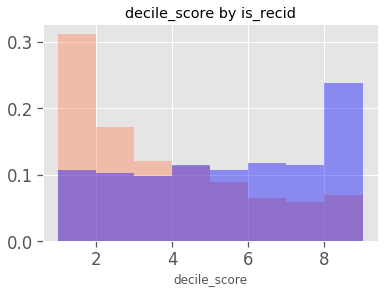

In [12]:
bin_plot(complete_scores, "decile_score", "is_recid", n_bins=10)

Decile scores are uniform among individuals who did recidivate and right skew among those that did not.

#### Qualitative Scores

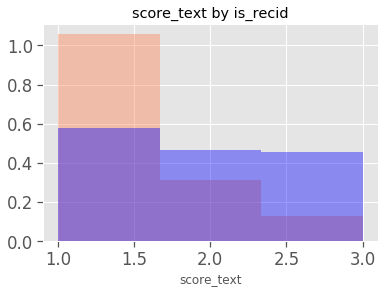

In [13]:
bin_plot(complete_scores, "score_text", "is_recid", bins=3)

Qualitative scores a mapped onto a 1, 2, 3 (low, medium, high) scale. We see a similar pattern to the decile scores since they're just a collapsed version.

## 2. Calculate AUC ROC Data for each Outcome and Transformation
Now that the data is merged, we'll calculate the AUC ROC value for each transformation. 

In [14]:
def calculate_roc(outcome, score, transformation_name, outcome_name):
    results = complete_scores[complete_scores[outcome].notnull()]
    auc = roc_auc_score(results[outcome], results[score])
    results = {
        "transformation": transformation_name,
        "outcome": outcome_name,
        "auc": auc,
    }
    return results

In [15]:
roc_data = [
    calculate_roc("is_recid", "r_raw_score", "Raw", "General Recidivism"),
    calculate_roc("is_violent_recid", "v_raw_score", "Raw", "Violent Recidivism"),
    calculate_roc("is_recid", "decile_score", "Decile", "General Recidivism"),
    calculate_roc("is_violent_recid", "v_decile_score", "Decile", "Violent Recidivism"),
    calculate_roc("is_recid", "score_text", "Qualitative", "General Recidivism"),
    calculate_roc(
        "is_violent_recid", "v_score_text", "Qualitative", "Violent Recidivism"
    ),
]

In [16]:
roc_df = pd.DataFrame(roc_data)
roc_df[["outcome", "transformation", "auc"]].round(3)

,outcome,transformation,auc
0,General Recidivism,Raw,0.725
1,Violent Recidivism,Raw,0.724
2,General Recidivism,Decile,0.714
3,Violent Recidivism,Decile,0.716
4,General Recidivism,Qualitative,0.678
5,Violent Recidivism,Qualitative,0.665


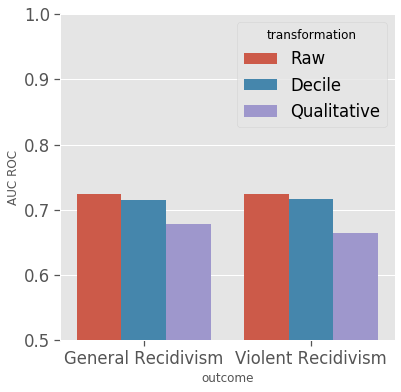

In [17]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.barplot(y="auc", x="outcome", data=roc_df, hue="transformation", ax=ax)
ax.set_ylim((0.5, 1))
ax.set_ylabel("AUC ROC");

### Accuracy of COMPAS scores by transformation
For the COMPAS tool, the accuracy of the model decreases as the number of bins gets smaller. The raw scores have the highest ROC values, but not much higher than the decile scores. In Northpointe's rebuttal, they achieved AUC scores on the ProPublica sample of 0.69 for general recidivism and 0.68 for violent in evaluating the decile scores. ([source, p. 3](http://go.volarisgroup.com/rs/430-MBX-989/images/ProPublica_Commentary_Final_070616.pdf))

## 3. What's the general case?
What happens to ROC scores as deciles are composed out of model scores? To find out, we can generate some simulated data. This simulated data is not from a particular model, but is meant to represent a hypothetical model output of scores for positive and negative cases. For simplicity, we'll choose a beta distribution for the model output scores and assume our model has some predictive power, where the scores from the model predicting positive classes is generally higher than those where the model predicts a negative outcome.

In addition, any cuts of data will be determined from the total distribution of scores. Comparitively, we don't know the original distribution of COMPAS scores (from when the assessment was developed) to map to the original decile scores -- we only use those available in the data.

We use a `Beta(2,2)` distribution to represent the scores of negative cases, and a `Beta(3.5, 2)` distribution for positive cases. There's no rationale for the parameters in these distributions except for applying them gives us hypothetical AUC scores in the same range as the COMPAS model.

### What does this hypothetical model output look like?
Below is a single simulated example from a hypothetical model -- the blue indicating the distribution of model scores for positvie cases and coral for negative cases. 

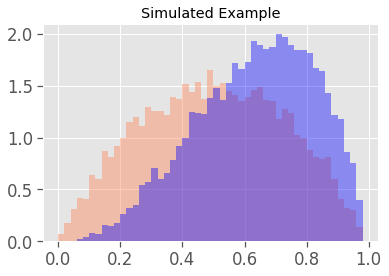

In [18]:
SAMPLE_SIZE = 10000

neg = scipy.random.beta(2, 2, size=SAMPLE_SIZE)
pos = scipy.random.beta(3.5, 2, size=SAMPLE_SIZE)
fig, ax = plt.subplots()
bins = np.arange(0, 1, 0.02)
sns.distplot(neg, ax=ax, bins=bins, kde=False, norm_hist=True, color="coral")
sns.distplot(pos, ax=ax, bins=bins, kde=False, norm_hist=True, color="blue")
ax.set_title("Simulated Example");

### Run simulations
The simulation below runs 500 simulations with 10000 samples for each simulation, resulting in 10000 simulated 'positive' cases and the same for 'negative' cases. We will apply quantile cuts ranging from 2 to 15 quantiles on the combined positive and negative predictions, as well as the case where no cuts are applied. From each simulated dataset the ROC is calculated.

In [19]:
def run_simulations(alpha_pos, alpha_neg, beta, qcuts, sample_size, n_sims):
    sim_data = []
    cuts = list(qcuts) + ["None"]
    for qcut in cuts:
        for sim in range(0, n_sims):
            pos = scipy.random.beta(alpha_pos, beta, size=sample_size)
            neg = scipy.random.beta(alpha_neg, beta, size=sample_size)
            roc_scores = np.hstack((neg, pos))
            if qcut != "None":
                roc_scores = pd.qcut(roc_scores, q=qcut, labels=False)
            roc_true = np.array([0] * len(neg) + [1] * len(pos))
            auc = roc_auc_score(roc_true, roc_scores)
            data = {"sim": sim, "AUC": auc, "qcut": qcut}
            sim_data.append(data)
    return pd.DataFrame(sim_data)

In [20]:
sim_df = run_simulations(
    alpha_pos=3.5,
    alpha_neg=2,
    beta=2,
    qcuts=range(2, 16),
    sample_size=10000,
    n_sims=500,
)

### Plot Data

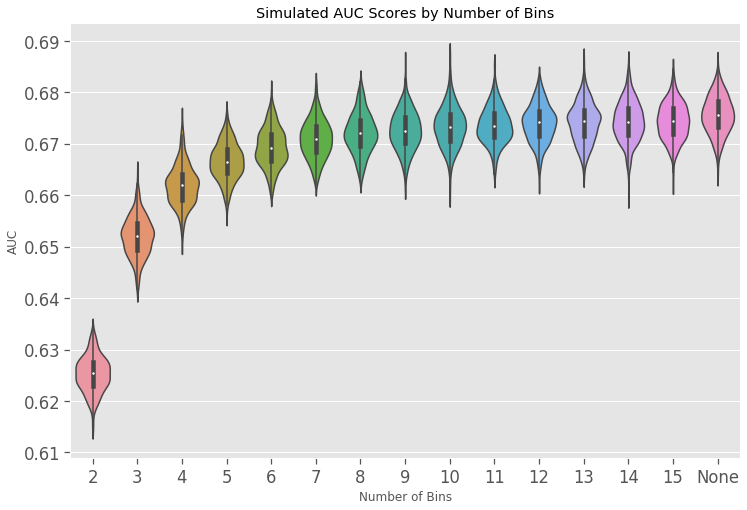

In [21]:
d = pd.DataFrame(sim_df)
fig, ax = plt.subplots(figsize=(12, 8))
sns.violinplot(data=d, x="qcut", y="AUC", ax=ax)
ax.set_xlabel("Number of Bins")
ax.set_title("Simulated AUC Scores by Number of Bins");

In [22]:
pd.DataFrame(d.groupby("qcut")["AUC"].agg(["median", "mean", "std"]).round(3)).T

qcut,2,3,4,5,6,7,8,9,10,11,12,13,14,15,None
median,0.625,0.652,0.662,0.667,0.669,0.671,0.672,0.673,0.673,0.673,0.674,0.674,0.674,0.674,0.676
mean,0.625,0.652,0.662,0.667,0.669,0.671,0.672,0.673,0.673,0.674,0.674,0.674,0.674,0.674,0.676
std,0.003,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004


### How the binning scheme impacts ROC scores
Binning schemes can generate ROC scores lower than the same model with no binning. In the hypothetical example above, the model results with no binning scheme achieved a median AUC of ~0.676, while the models with binary or ternary schemes achieved median AUC values of ~0.626 and ~0.652 respectively. This hypothetical example shows that binning schemes can have a negative impact on AUC values in comparison to the untransformed data. 

## Summary
The findings above show that when reporting model accuracy with AUC, a reader should be wary of any transformation scheme applied to the model output since that scheme can change the AUC value. 

We explored the impact of transformation schemes through the COMPAS dataset provided by ProPublica, demonstrating that when the final output of the model is qualitative scores, incomparison to decile scores or raw scores, the model has lower AUC. We then analyzed a hypothetical example to determine what the general case is when differing binning schemes are applied, inferring that binning schemes with a small number of bins in our hypothetical example can result in lower AUC scores.

In cases where the output of a model presented to a decision maker is transformed model results, there may be a discrepancy in the accuracy of those presented outputs in comparison to reported accuracy from evaluations. It is important to analyze risk assessments and other models in practice in context of what information is presented to decision makers.

## Helpful Resources
- Tom Augspurger's [post on method chaining](https://tomaugspurger.github.io/method-chaining.html) was instrumental in refactoring the data reading steps